# Bayes Factor Experiment with Optional Stopping

In [37]:
using ProgressMeter: @showprogress
using DataFrames

using PrettyTables
using Random
using Query
using StatsPlots

using BayesianExperiments

# number of columns in a dataframe to show 
ENV["COLUMNS"] = 200;

Optional stopping refers to the practice of peeking at data and make decision whether or not to continue an experiment. Such practice is usually prohibited in the frequentist AB testing framework. By using simulation-based result, **Rouder (2014)**[2] showed that a Bayes factor experiment with optional stopping can be valid with proper interpretation of the Bayesian quantities. 

This notebook follows the examples in **Schönbrodt et al. (2016)**[1] to conduct the error analysis of Bayes factor based experiment with optional stopping.

The simulation will be conducted by following steps:

1. Choose a threshold of Bayes factor for decision making. For example, if the threshold is set to 10, when a Bayes factor of $\text{BF}_{10}$ is larger than 10, or less than 1/10, we decide we have collected enough evidence and stop the experiment.
2. Choose a prior distribituion for the effect size under $H_1$. We will use the `StudentTEffectSize` model in the package. You can check the definition of `NormalEffectSize` model from the docstring by typing `?NormalEffectSize`.
3. Run a minimum number of steps (20 as the same in the paper), increase the sample size. Compute the bayes factor at each step.
4. As soon as the bayes factor value reached or exceeded the one of the thresholds as set in (1), or the maximum number of steps is reached, we will stop the experiment.

Some constants used in the simulation:

* Number of simulations: 5000
* Minimum number of steps: 20

The simulation function can be quickly created based on our package:

In [38]:
function simulate(δ, n, σ0; r=0.707, thresh=9, minsample=20)
    # we will use two-sided decision rule for bayes factor
    rule = TwoSidedBFThresh(thresh)
    
    # the prior distribution of effect size,
    # r is the standard deviation
    model = StudentTEffectSize(r=r)
    
    # setup the experiment
    experiment = ExperimentBF(model=model, rule=rule)
    
    # create a sample with size n, the effect size is 
    # specified as δ
    xs = rand(Normal(δ, 1), n)
    
    i = 0
    # specify the stopping condition
    while (i < n) & (experiment.winner === nothing)
        i += 1
        
        # if minimum number of sample is not reached, 
        # keep collecting data
        if i < minsample
            continue
        end
        
        stats = NormalStatistics(xs[1:i])
        experiment.stats = stats
        decide!(experiment)
    end
    experiment
end

# df table print helper
printtable(df) = pretty_table(df, tf=tf_markdown, nosubheader=true, header_crayon=Crayon(bold=:false))

printtable (generic function with 1 method)

## Case when alternative $\delta = 0$

When alternative $\delta > 0$, the error rate relates to the false positive rate. 

In [39]:
#deltas = collect(range(0, 1.5, step=0.2));
delta = 0.0
rs = [0.707, 1.0, 1.414];
threshs = [3, 5, 7, 10];
totalnum = length(rs)*length(threshs);

paramsgrid = reshape(collect(Base.Iterators.product(rs, threshs)), (totalnum, 1));
paramsgrid = [(r=r, thresh=thresh) for (r, thresh) in paramsgrid];
@show length(paramsgrid);

length(paramsgrid) = 12


In [40]:
n =  1000
ns = 5000
minsample = 20

sim_result1 = DataFrame(
    delta=Float64[], 
    r=Float64[], 
    thresh=Float64[], 
    num_sim=Int64[], 
    num_null=Int64[], 
    num_alt=Int64[],
    err_rate=Float64[], 
    avg_sample_size=Int64[])

@showprogress for params in paramsgrid
    delta = 0
    r = params.r
    thresh = params.thresh
    winners = []
    samplesizes = []
    for _ in 1:ns
        experiment = simulate(delta, n, r, thresh=thresh, minsample=minsample)
        push!(winners, experiment.winner)
        push!(samplesizes, experiment.stats.n)
    end
    
    num_null = sum(winners .== "null")
    num_alt = sum(winners .== "alternative")
    
    err_rate = num_alt/ns
    avg_sample_size = mean(samplesizes)
    push!(sim_result1, (delta, r, thresh, ns, num_null, num_alt, err_rate, convert(Int64, round(avg_sample_size))))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


In [41]:
printtable(sim_result1)

| delta |     r | thresh | num_sim | num_null | num_alt | err_rate | avg_sample_size |
|-------|-------|--------|---------|----------|---------|----------|-----------------|
|   0.0 | 0.707 |    3.0 |    5000 |     4666 |     334 |   0.0668 |              24 |
|   0.0 |   1.0 |    3.0 |    5000 |     4704 |     296 |   0.0592 |              24 |
|   0.0 | 1.414 |    3.0 |    5000 |     4711 |     289 |   0.0578 |              24 |
|   0.0 | 0.707 |    5.0 |    5000 |     4718 |     282 |   0.0564 |              48 |
|   0.0 |   1.0 |    5.0 |    5000 |     4720 |     280 |    0.056 |              49 |
|   0.0 | 1.414 |    5.0 |    5000 |     4732 |     268 |   0.0536 |              48 |
|   0.0 | 0.707 |    7.0 |    5000 |     4737 |     250 |     0.05 |             101 |
|   0.0 |   1.0 |    7.0 |    5000 |     4764 |     226 |   0.0452 |              99 |
|   0.0 | 1.414 |    7.0 |    5000 |     4752 |     241 |   0.0482 |             100 |
|   0.0 | 0.707 |   10.0 |    5000 |     47

## Case when alternative $\delta > 0$

We create a grid of combinations of all parameters.

In [6]:
deltas = collect(range(0.1, 1.0, step=0.2));
rs = [0.707, 1.0, 1.414];
threshs = [3, 5, 7, 10];
totalnum = length(deltas)*length(rs)*length(threshs);

paramsgrid = reshape(collect(Base.Iterators.product(deltas, rs, threshs)), (totalnum, 1));
paramsgrid = [(delta=delta, r=r, thresh=thresh) for (delta, r, thresh) in paramsgrid]
@show length(paramsgrid);
@show paramsgrid[1:5];

length(paramsgrid) = 60
paramsgrid[1:5] = NamedTuple{(:delta, :r, :thresh),Tuple{Float64,Float64,Int64}}[(delta = 0.1, r = 0.707, thresh = 3), (delta = 0.3, r = 0.707, thresh = 3), (delta = 0.5, r = 0.707, thresh = 3), (delta = 0.7, r = 0.707, thresh = 3), (delta = 0.9, r = 0.707, thresh = 3)]


The simulation is similar to the $\delta=0$ case. When alternative $\delta > 0$, the error rate relates to the false negative evidence.

In [7]:
n =  1000
ns = 5000
minsample = 20

sim_result2 = DataFrame(
    delta=Float64[], 
    r=Float64[], 
    thresh=Float64[], 
    num_sim=Int64[], 
    num_null=Int64[], 
    num_alt=Int64[],
    err_rate=Float64[], 
    avg_sample_size=Int64[])

@showprogress for params in paramsgrid
    delta=params.delta
    r = params.r
    thresh = params.thresh
    winners = []
    samplesizes = []
    for _ in 1:ns
        experiment = simulate(delta, n, r, thresh=thresh, minsample=minsample)
        push!(winners, experiment.winner)
        push!(samplesizes, experiment.stats.n)
    end
    
    num_null = sum(winners .== "null")
    num_alt = sum(winners .== "alternative")
    err_rate = 1-num_alt/ns
    avg_sample_size = mean(samplesizes)
    push!(sim_result2, (delta, r, thresh, ns, num_null, num_alt, 
            err_rate, convert(Int64, round(avg_sample_size))))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:31


Simulation result when $\delta=0.5$

In [93]:
sim_result2 |>
    @filter(_.delta==0.5)|>
    @orderby(_.delta) |> @thenby(_.r) |>
    df -> printtable(DataFrame(df))

| delta |     r | thresh | num_sim | num_null | num_alt | err_rate | avg_sample_size |
|-------|-------|--------|---------|----------|---------|----------|-----------------|
|   0.5 | 0.707 |    3.0 |    5000 |      694 |    4306 |   0.1388 |              26 |
|   0.5 | 0.707 |    5.0 |    5000 |       82 |    4918 |   0.0164 |              33 |
|   0.5 | 0.707 |    7.0 |    5000 |        0 |    5000 |      0.0 |              36 |
|   0.5 | 0.707 |   10.0 |    5000 |        0 |    5000 |      0.0 |              39 |
|   0.5 |   1.0 |    3.0 |    5000 |      674 |    4326 |   0.1348 |              25 |
|   0.5 |   1.0 |    5.0 |    5000 |       90 |    4910 |    0.018 |              33 |
|   0.5 |   1.0 |    7.0 |    5000 |        3 |    4997 |   0.0006 |              37 |
|   0.5 |   1.0 |   10.0 |    5000 |        0 |    5000 |      0.0 |              40 |
|   0.5 | 1.414 |    3.0 |    5000 |      746 |    4254 |   0.1492 |              26 |
|   0.5 | 1.414 |    5.0 |    5000 |       

## Evaluate the simulation result with Type I & II Error and FDR

As pointed out by [2], we can evaluate the simulation result from the perspective of false discovery rate. Here we assume there is a 50-50 chance that the data is from either the null model or alternative model. 

We can merge the two simulations results by the prior standard deviation $r$ and threshold of bayes factor. In the merged dataframe, each row represents a simulation with the 5000 samples from the null model and 5000 samples from the alternative model with the corresponding parameters ($r$, $thresh$, $\delta_1$).

In [48]:
sim_result = leftjoin(sim_result1, sim_result2, 
    on=[:r, :thresh, :num_sim],
    renamecols= "_0" => "_1"
);

sim_result.num_dis = sim_result.num_alt_0 + sim_result.num_alt_1;
sim_result.num_false_dis = sim_result.num_alt_0;
sim_result.fdr = sim_result.num_false_dis ./ sim_result.num_dis;

sim_result.type1_error = sim_result.num_alt_0 ./ sim_result.num_sim;
#sim_result.type2_error = 1 .- sim_result.num_alt_1 ./ sim_result.num_sim;
sim_result.power = sim_result.num_alt_1 ./ sim_result.num_sim;

sim_result = sim_result |>
    df -> select(df, [:delta_1, :r, :thresh, :num_sim, :num_alt_0, :num_alt_1, :type1_error, :power, :fdr]);

Examples from merged dataframe:

In [98]:
sim_result |>
    @filter(((_.delta_1 == 0.1) .& (_.r == 0.707)) .|
            ((_.delta_1 == 0.1) .& (_.r == 1.0))  .|
            ((_.delta_1 == 0.3) .& (_.r == 1.0)) .|
            ((_.delta_1 == 0.3) .& (_.r == 1.414))) |>
    @orderby(_.delta_1) |> @thenby(_.r) |> @thenby(_.thresh) |>
    df -> printtable(DataFrame(df))

| delta_1 |     r | thresh | num_sim | num_alt_0 | num_alt_1 | type1_error |  power |       fdr |
|---------|-------|--------|---------|-----------|-----------|-------------|--------|-----------|
|     0.1 | 0.707 |    3.0 |    5000 |       334 |       568 |      0.0668 | 0.1136 |  0.370288 |
|     0.1 | 0.707 |    5.0 |    5000 |       282 |       812 |      0.0564 | 0.1624 |   0.25777 |
|     0.1 | 0.707 |    7.0 |    5000 |       250 |      1335 |        0.05 |  0.267 |  0.157729 |
|     0.1 | 0.707 |   10.0 |    5000 |       169 |      2102 |      0.0338 | 0.4204 | 0.0744166 |
|     0.1 |   1.0 |    3.0 |    5000 |       296 |       542 |      0.0592 | 0.1084 |  0.353222 |
|     0.1 |   1.0 |    5.0 |    5000 |       280 |       810 |       0.056 |  0.162 |  0.256881 |
|     0.1 |   1.0 |    7.0 |    5000 |       226 |      1329 |      0.0452 | 0.2658 |  0.145338 |
|     0.1 |   1.0 |   10.0 |    5000 |       187 |      2035 |      0.0374 |  0.407 | 0.0841584 |
|     0.3 |   1.0 | 

Let's visualize the result to better understand what is happening:

In [120]:
r_labels = hcat(["r=$val" for val in rs]...);

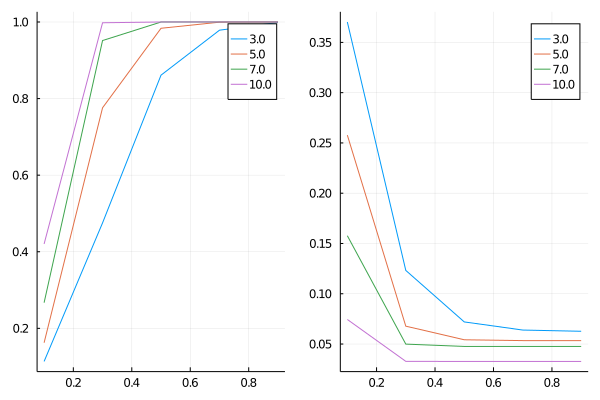

In [64]:
sim_result |>
    @filter(_.r==0.707) |>
    @df plot(
        plot(:delta_1, [:power], group=(:thresh)),
        plot(:delta_1, [:fdr], group=(:thresh)),
    )

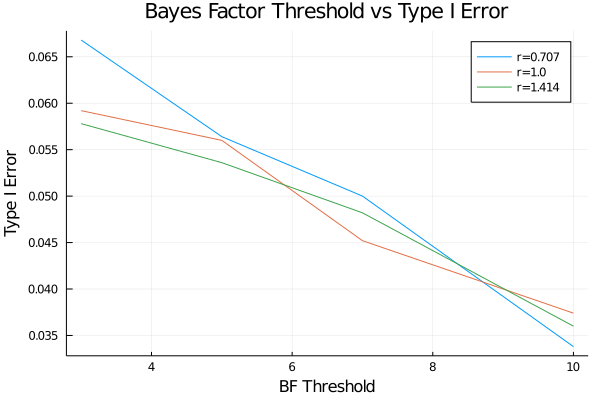

In [124]:
p0 = sim_result |>
    @filter(_.delta_1==0.1) |>
    @df plot(:thresh, [:type1_error], 
             group=(:r), 
             label=r_labels,
             title="Bayes Factor Threshold vs Type I Error",
             xlabel="BF Threshold",
             ylabel="Type I Error",
             legend=true)

In [104]:
p1 = sim_result |>
    @filter(_.delta_1==0.1) |>
    @df plot(
        plot(:thresh, [:power], group=(:r)),
        plot(:thresh, [:fdr], group=(:r)),
    )

p2 = sim_result |>
    @filter(_.delta_1==0.3) |>
    @df plot(
        plot(:thresh, [:power], group=(:r)),
        plot(:thresh, [:fdr], group=(:r)),
    );

p3 = sim_result |>
    @filter(_.delta_1==0.7) |>
    @df plot(
        plot(:thresh, [:power], group=(:r)),
        plot(:thresh, [:fdr], group=(:r)),
    );

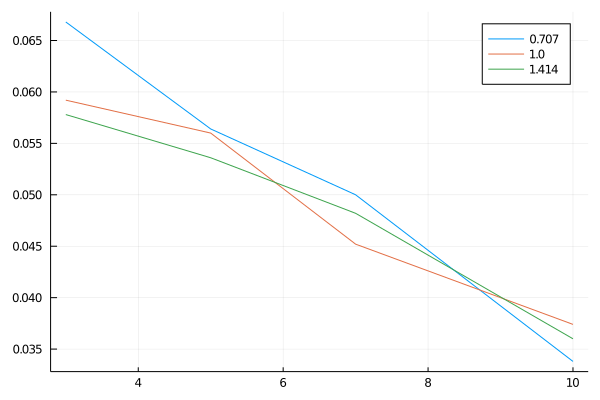

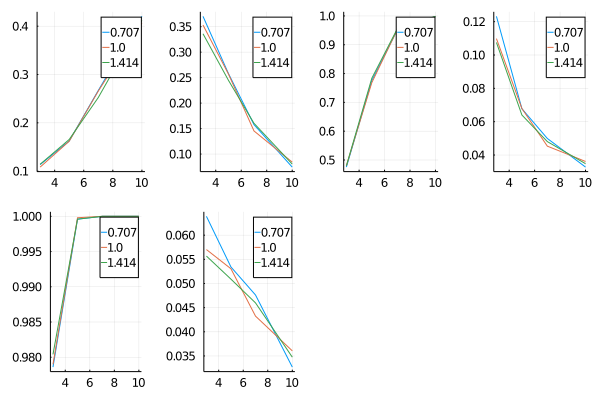

In [84]:
plot(p1, p2, p3)

## References

1. Schönbrodt, Felix D., Eric-Jan Wagenmakers, Michael Zehetleitner, and Marco Perugini. "Sequential hypothesis testing with Bayes factors: Efficiently testing mean differences." Psychological methods 22, no. 2 (2017): 322.
2. Deng, Alex, Jiannan Lu, and Shouyuan Chen. "Continuous monitoring of A/B tests without pain: Optional stopping in Bayesian testing." In 2016 IEEE international conference on data science and advanced analytics (DSAA), pp. 243-252. IEEE, 2016.
3. Rouder, Jeffrey N. "Optional stopping: No problem for Bayesians." Psychonomic bulletin & review 21, no. 2 (2014): 301-308.